# Summary
This notebook explores the use of DistilBERT for two tasks:

- Multi-label emotion classification on the GoEmotions dataset

- Binary suicide risk detection on SuicideWatch posts

The objective is to train lightweight wrapper models that can classify input texts and return structured system prompts — as a backend for potential chatbot integration.

In [1]:
# Cell 1: imports + device + random seed

import os
import numpy as np
import pandas as pd
import torch

from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    f1_score,
    precision_score,
    recall_score,
)
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    set_seed,
)
import transformers

print("torch version:", torch.__version__)
print("transformers version:", transformers.__version__)

# Reproducibility
set_seed(42)

# Device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# multi-label stratified split
!pip install -q scikit-multilearn
from skmultilearn.model_selection import iterative_train_test_split


2025-11-29 12:23:05.655677: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764418985.836991      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764418985.885060      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

torch version: 2.6.0+cu124
transformers version: 4.53.3
Using device: cuda


## Environment & Dependencies

- Verifies `torch`/`transformers` versions, switches to GPU when Kaggle provides T4s, and seeds every library via `set_seed(42)` for repeatable experiments.
- Installs Kaggle-only extras such as `scikit-multilearn` so the notebook remains portable to local machines that may not have the package cached.
- Keeps `device` as a single source of truth so every downstream model / tensor call just uses `.to(device)`.


In [2]:
# Cell 2: load datasets from Kaggle input
go_path = os.path.join("/kaggle/input/go-emotions-google-emotions-dataset/go_emotions_dataset.csv")
sw_path = os.path.join("/kaggle/input/suicide-watch/Suicide_Detection.csv")

print("GoEmotions path:", go_path)
print("SuicideWatch path:", sw_path)

go_df = pd.read_csv(go_path)
print("GoEmotions Dataset by Google!")
go_df.info()

sw_df = pd.read_csv(sw_path)
print("\n\nSuicide Watch Dataset By Nikhileswar Komati!")
sw_df.info()


GoEmotions path: /kaggle/input/go-emotions-google-emotions-dataset/go_emotions_dataset.csv
SuicideWatch path: /kaggle/input/suicide-watch/Suicide_Detection.csv
GoEmotions Dataset by Google!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211225 entries, 0 to 211224
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    211225 non-null  object
 1   text                  211225 non-null  object
 2   example_very_unclear  211225 non-null  bool  
 3   admiration            211225 non-null  int64 
 4   amusement             211225 non-null  int64 
 5   anger                 211225 non-null  int64 
 6   annoyance             211225 non-null  int64 
 7   approval              211225 non-null  int64 
 8   caring                211225 non-null  int64 
 9   confusion             211225 non-null  int64 
 10  curiosity             211225 non-null  int64 
 11  desire                211225 no

## Dataset Access & Local Copies

- When running in Kaggle, read GoEmotions and SuicideWatch CSVs directly from `/kaggle/input` and print schema snapshots for sanity checks.
- The fallback cell that follows re-downloads both datasets with `gdown` into the repo's `Data/` folder, guaranteeing that the notebook works outside Kaggle as well.
- Having both paths available keeps the rest of the pipeline agnostic to the execution environment; it always receives fully-populated `go_df` / `sw_df` DataFrames.


## Portable Dataset Downloads

If `/kaggle/input` isn't available (e.g., running locally), this block fetches both CSVs via `gdown` into the repo's `Data/` folder and ensures the downstream pipeline reads the same schemas.


In [3]:
!pip install -q gdown
import os, pandas as pd

os.makedirs("Data", exist_ok=True)

# Download GoEmotions dataset
!rm -f Data/go_emotions_dataset.csv
!gdown "https://drive.google.com/uc?id=1b_b1WaPBmhXTeTFXu3CoZmbPsMKYCCx9" -O "Data/go_emotions_dataset.csv"

go_df = pd.read_csv("Data/go_emotions_dataset.csv")
print("GoEmotions Dataset by Google!")
go_df.info()
go_df.head()

# Download Suicide Detection dataset
!rm -f Data/Suicide_Detection.csv
!gdown "https://drive.google.com/uc?id=1aoKAJwWZFDljOMp98i06xhuHryjQXbD6" -O "Data/Suicide_Detection.csv"

sw_df = pd.read_csv("Data/Suicide_Detection.csv")
print("\n\nSuicide Watch Dataset By Nikhileswar Komati!")
sw_df.info()
sw_df.head()

Downloading...
From: https://drive.google.com/uc?id=1b_b1WaPBmhXTeTFXu3CoZmbPsMKYCCx9
To: /kaggle/working/Data/go_emotions_dataset.csv
100%|██████████████████████████████████████| 29.9M/29.9M [00:01<00:00, 23.1MB/s]
GoEmotions Dataset by Google!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211225 entries, 0 to 211224
Data columns (total 31 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   id                    211225 non-null  object
 1   text                  211225 non-null  object
 2   example_very_unclear  211225 non-null  bool  
 3   admiration            211225 non-null  int64 
 4   amusement             211225 non-null  int64 
 5   anger                 211225 non-null  int64 
 6   annoyance             211225 non-null  int64 
 7   approval              211225 non-null  int64 
 8   caring                211225 non-null  int64 
 9   confusion             211225 non-null  int64 
 10  curiosity             2112

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


## Runtime Diagnostics

Lightweight `nvidia-smi` probe captures the active GPU + driver versions so later reviewers can correlate training speed with the available hardware.


In [4]:
!nvidia-smi

Sat Nov 29 12:23:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   36C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Cell 3: preprocessing GoEmotions & SuicideWatch

# Filter out unclear examples
go_df = go_df[go_df["example_very_unclear"] == False]

# Extract emotion columns (from 'admiration' to 'neutral')
emotion_cols = go_df.columns[3:]
go_df = go_df[go_df[emotion_cols].sum(axis=1) > 0]  # remove empty labels

# Extract X (texts reshaped as array) and Y (multi-label binary matrix)
X = go_df["text"].values.reshape(-1, 1)
Y = go_df[emotion_cols].values

# Stratified multi-label split (10k train)
X_train, Y_train, X_test, Y_test = iterative_train_test_split(
    X, Y, test_size=1 - (10_000 / len(go_df))
)

# Flatten and reconstruct
texts_go = X_train.ravel().tolist()
labels_go = Y_train

texts_go_test = X_test.ravel().tolist()
labels_go_test = Y_test

label_counts = pd.DataFrame(labels_go, columns=emotion_cols).sum().sort_values()
print(label_counts)

# SuicideWatch preprocessing
sw_df["class"] = sw_df["class"].str.lower().str.strip()
sw_df = sw_df[sw_df["class"].isin(["suicide", "non-suicide"])]
sw_df["label"] = sw_df["class"].map({"non-suicide": 0, "suicide": 1})

# Sample 10k for training (keep balance with stratify)
sw_df_sample, _ = train_test_split(
    sw_df,
    train_size=10_000,
    stratify=sw_df["label"].values,
    random_state=42,
)
train_indices_sw = sw_df_sample.index

# Final train data
texts_sw = sw_df.loc[train_indices_sw, "text"].tolist()
labels_sw = sw_df.loc[train_indices_sw, "label"].values

# Final held-out test data
sw_df_test = sw_df.drop(index=train_indices_sw).reset_index(drop=True)
texts_sw_test = sw_df_test["text"].tolist()
labels_sw_test = sw_df_test["label"].values

print(sw_df_sample["label"].value_counts())


grief               32
relief              62
pride               63
nervousness         87
embarrassment      119
remorse            122
fear               154
desire             184
disgust            255
surprise           265
excitement         271
caring             289
sadness            325
confusion          354
joy                384
anger              389
love               394
disappointment     408
optimism           419
realization        423
amusement          445
curiosity          466
disapproval        550
gratitude          559
annoyance          655
admiration         824
approval           848
neutral           2661
dtype: int64
label
1    5000
0    5000
Name: count, dtype: int64


## Preprocessing & Split Strategy

- Remove GoEmotions rows flagged as `example_very_unclear`, drop empty-label comments, and stratify a 10k subset with `iterative_train_test_split` to preserve label frequency.
- Normalize SuicideWatch `class` strings, map them to binary labels, and sample a balanced 10k training set while keeping the rest as a strict hold-out test table.
- Show per-label counts so later evaluation charts have context on which categories are inherently rare.


## Multi-Label Toolkit

`scikit-multilearn` supplies `iterative_train_test_split`, which keeps multi-label frequency balanced—this quick install makes sure the helper exists even outside Kaggle.


In [6]:
!pip install scikit-multilearn

In [7]:
# Cell 4: metrics + custom trainer

label_counts = np.sum(labels_go, axis=0) + 1e-6  # shape: [num_classes]
total_samples = labels_go.shape[0]

neg_counts = total_samples - label_counts
pos_weight = neg_counts / label_counts

class_weights = torch.tensor(pos_weight, dtype=torch.float)

def compute_metrics_sw(p):
    preds = p.predictions.argmax(axis=1)
    labels = p.label_ids

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary"
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score, precision_score, recall_score

def hamming_score(y_true, y_pred):
    # Sample-wise Jaccard
    acc_list = []
    for true, pred in zip(y_true, y_pred):
        if np.sum(true) == 0 and np.sum(pred) == 0:
            acc_list.append(1)
        else:
            acc_list.append(
                np.sum(np.logical_and(true, pred))
                / np.sum(np.logical_or(true, pred))
            )
    return np.mean(acc_list)

def compute_metrics_goemo(p):
    labels = p.label_ids
    logits = torch.tensor(p.predictions)  # logits
    probs = torch.sigmoid(logits)         # sigmoid
    preds = (probs > 0.5).int().numpy()   # threshold

    return {
        "hamming_score": hamming_score(labels, preds),
        "f1_micro": f1_score(labels, preds, average="micro", zero_division=0),
        "f1_macro": f1_score(labels, preds, average="macro", zero_division=0),
        "precision_micro": precision_score(labels, preds, average="micro", zero_division=0),
        "recall_micro": recall_score(labels, preds, average="micro", zero_division=0),
    }

from torch.nn import BCEWithLogitsLoss

class CustomLossTrainer(Trainer):
    def __init__(self, *args, pos_weight=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.pos_weight = pos_weight

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        loss_fct = torch.nn.BCEWithLogitsLoss(
            pos_weight=self.pos_weight.to(logits.device)
        )
        loss = loss_fct(logits, labels.float())

        return (loss, outputs) if return_outputs else loss


## Loss & Metric Design

- Define `compute_metrics_sw` for binary accuracy/F1/precision/recall plus a custom `hamming_score` helper for the multi-label task.
- `compute_metrics_goemo` thresholds sigmoid outputs at 0.5 and reports micro/macro F1 along with micro precision/recall so we can diagnose class-imbalance behavior.
- `CustomLossTrainer` subclasses Hugging Face's `Trainer` to plug in BCEWithLogits loss with per-class `pos_weight`, which directly counters the long-tail label distribution in GoEmotions.


## Training Setup & Visual Diary

**GoEmotions multi-label pipeline**
- Filter rows marked `example_very_unclear` and keep only comments with >=1 annotated label before sampling 10k texts via `iterative_train_test_split`.
- DistilBERT base uncased (max length 128, batch size 8, 10 epochs) is fine-tuned with `CustomLossTrainer` + BCEWithLogits class weights to counter the long-tail label distribution.
- Splits preserve the original Kaggle IDs so raw Reddit metadata can be reattached downstream.

![GoEmotions training loss](visuals/go_train_loss.png)
![GoEmotions validation loss](visuals/go_val_loss.png)
![GoEmotions micro-F1 over epochs](visuals/go_eval_f1_micro.png)
![GoEmotions macro-F1 over epochs](visuals/go_eval_f1_macro.png)
![GoEmotions Hamming score](visuals/go_eval_hamming_score.png)

**SuicideWatch binary pipeline**
- Normalize `class` labels to `suicide` / `non-suicide`, sample a balanced 10k subset for training, and keep the remaining posts as a strict held-out test set.
- DistilBERT base uncased (max length 256, batch size 8, 3 epochs) is trained with the standard cross-entropy loss and the same HF logging hooks.
- Metrics are logged through the Hugging Face `Trainer` loop so the figures double as monitoring dashboards.

![SuicideWatch training loss](visuals/sw_train_loss.png)
![SuicideWatch validation loss](visuals/sw_val_loss.png)
![SuicideWatch accuracy](visuals/sw_eval_accuracy.png)
![SuicideWatch precision](visuals/sw_eval_precision.png)
![SuicideWatch recall](visuals/sw_eval_recall.png)
![SuicideWatch F1](visuals/sw_eval_f1.png)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Hamming Score,F1 Micro,F1 Macro,Precision Micro,Recall Micro
1,1.079000,1.005747,0.153889,0.228813,0.215817,0.136094,0.717917
2,0.838800,0.989917,0.178514,0.244298,0.220941,0.148395,0.690622
3,0.640800,1.105751,0.210369,0.280951,0.256524,0.176054,0.695123
4,0.475100,1.403873,0.249695,0.318376,0.283970,0.212068,0.638396
5,0.391300,1.593461,0.248631,0.314610,0.285658,0.212618,0.604664
6,0.290800,1.842940,0.277434,0.330140,0.296219,0.234628,0.556803
7,0.235500,2.226354,0.292394,0.346548,0.310022,0.257209,0.530978
8,0.188700,2.339085,0.299024,0.345428,0.310327,0.263473,0.501389
9,0.164800,2.600455,0.315799,0.360703,0.313058,0.288341,0.481551
10,0.149200,2.711857,0.320920,0.363950,0.315599,0.297455,0.468736


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

Index(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step', 'eval_loss',
       'eval_hamming_score', 'eval_f1_micro', 'eval_f1_macro',
       'eval_precision_micro', 'eval_recall_micro', 'eval_runtime',
       'eval_samples_per_second', 'eval_steps_per_second', 'train_runtime',
       'train_samples_per_second', 'train_steps_per_second', 'total_flos',
       'train_loss'],
      dtype='object')
     loss  grad_norm  learning_rate     epoch  step  eval_loss  \
0  1.3098   1.077665       0.000050  0.080128    50        NaN   
1  1.2992   1.776804       0.000049  0.160256   100        NaN   
2  1.1858   1.877390       0.000049  0.240385   150        NaN   
3  1.1469   3.354511       0.000048  0.320513   200        NaN   
4  1.1552   2.208108       0.000048  0.400641   250        NaN   

   eval_hamming_score  eval_f1_micro  eval_f1_macro  eval_precision_micro  \
0                 NaN            NaN            NaN                   NaN   
1                 NaN            NaN            

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


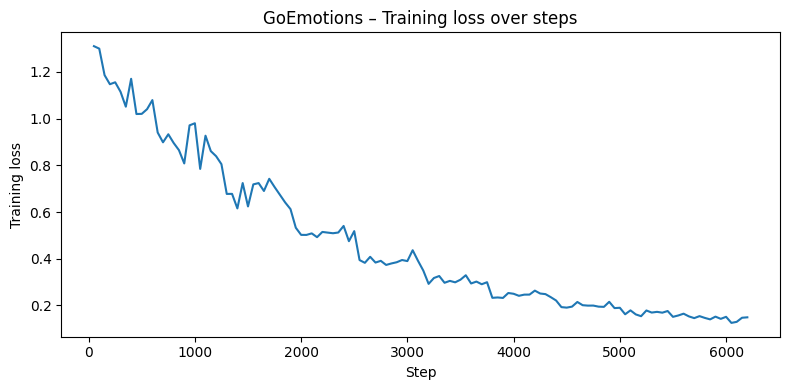

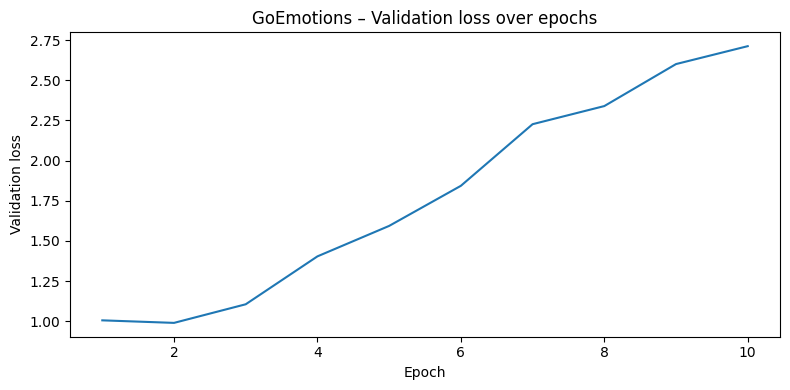

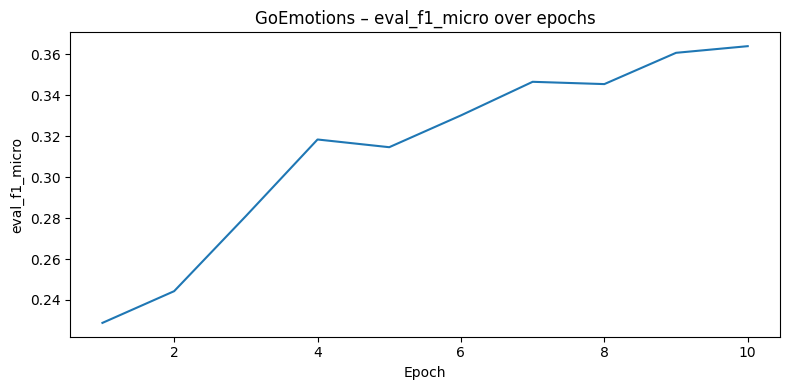

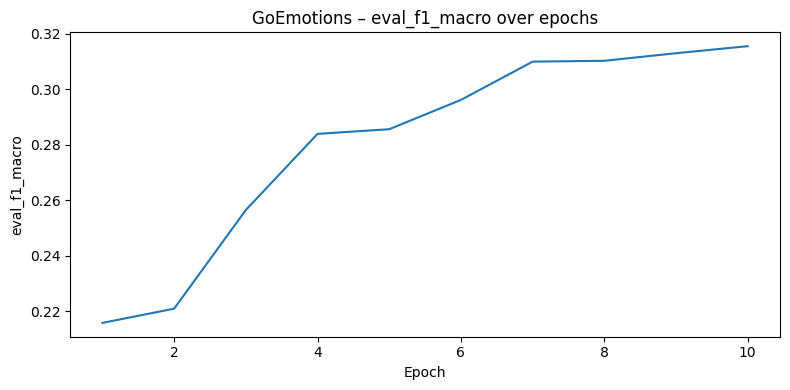

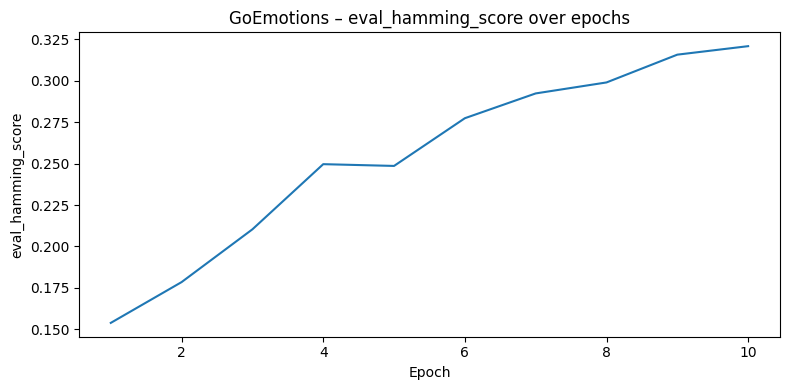

('./model_go/tokenizer_config.json',
 './model_go/special_tokens_map.json',
 './model_go/vocab.txt',
 './model_go/added_tokens.json',
 './model_go/tokenizer.json')

In [8]:
# Cell 5: GoEmotions DistilBERT (multi-label)

num_labels = len(emotion_cols)

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels,
    problem_type="multi_label_classification",  # important for multi-label
).to(device)

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


class GoEmotionDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        inputs = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),       # safer than squeeze()
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.float),
        }


train_dataset = GoEmotionDataset(texts_go,      labels_go,      tokenizer)
eval_dataset  = GoEmotionDataset(texts_go_test, labels_go_test, tokenizer)

# ---- label metadata for deployment ----
id2label_go = {i: lab for i, lab in enumerate(emotion_cols)}
label2id_go = {lab: i for i, lab in id2label_go.items()}

model.config.id2label = id2label_go
model.config.label2id = label2id_go
model.config.problem_type = "multi_label_classification"

# ---- training arguments ----
train_args = TrainingArguments(
    output_dir="./results_go",
    eval_strategy="epoch",       # your HF version uses eval_strategy
    logging_strategy="steps",
    logging_steps=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,
    logging_dir="./logs_go",
    save_strategy="no",
    disable_tqdm=False,
    report_to="none",
    seed=42,                     # keep training deterministic
)

trainer = CustomLossTrainer(
    model=model,
    args=train_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics_goemo,
    pos_weight=class_weights,
)

trainer.train()

import matplotlib.pyplot as plt

# Convert training log history to DataFrame
os.makedirs("figures", exist_ok=True)  # all plots will go here

log_go = pd.DataFrame(trainer.state.log_history)
print(log_go.columns)
print(log_go.head())

# ---- 1) Training loss vs steps ----
train_loss_go = log_go[log_go["loss"].notna()]

plt.figure(figsize=(8, 4))
plt.plot(train_loss_go["step"], train_loss_go["loss"])
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.title("GoEmotions – Training loss over steps")
plt.tight_layout()
plt.savefig("figures/go_train_loss.png", dpi=150)
plt.show()

# ---- 2) Validation loss vs epoch ----
eval_go = log_go[log_go["eval_loss"].notna()]

plt.figure(figsize=(8, 4))
plt.plot(eval_go["epoch"], eval_go["eval_loss"])
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.title("GoEmotions – Validation loss over epochs")
plt.tight_layout()
plt.savefig("figures/go_val_loss.png", dpi=150)
plt.show()

# ---- 3) Eval metrics vs epoch (optional, only if present) ----
for metric in ["eval_f1_micro", "eval_f1_macro", "eval_hamming_score"]:
    if metric in eval_go.columns:
        plt.figure(figsize=(8, 4))
        plt.plot(eval_go["epoch"], eval_go[metric])
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.title(f"GoEmotions – {metric} over epochs")
        plt.tight_layout()
        fname = f"figures/go_{metric}.png"
        plt.savefig(fname, dpi=150)
        plt.show()

# save model + tokenizer for FastAPI
trainer.save_model("./model_go")
tokenizer.save_pretrained("./model_go")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.139400,0.135073,0.955000,0.956098,0.933333,0.980000
2,0.067300,0.108636,0.975000,0.974975,0.975952,0.974000
3,0.002000,0.121744,0.974000,0.973948,0.975904,0.972000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Index(['loss', 'grad_norm', 'learning_rate', 'epoch', 'step', 'eval_loss',
       'eval_accuracy', 'eval_f1', 'eval_precision', 'eval_recall',
       'eval_runtime', 'eval_samples_per_second', 'eval_steps_per_second',
       'train_runtime', 'train_samples_per_second', 'train_steps_per_second',
       'total_flos', 'train_loss'],
      dtype='object')
     loss  grad_norm  learning_rate    epoch  step  eval_loss  eval_accuracy  \
0  0.3888   6.829370       0.000049  0.08881    50        NaN            NaN   
1  0.2769   3.629891       0.000047  0.17762   100        NaN            NaN   
2  0.2605   4.403708       0.000046  0.26643   150        NaN            NaN   
3  0.1919   0.801371       0.000044  0.35524   200        NaN            NaN   
4  0.1759   2.874963       0.000043  0.44405   250        NaN            NaN   

   eval_f1  eval_precision  eval_recall  eval_runtime  \
0      NaN             NaN          NaN           NaN   
1      NaN             NaN          NaN           N

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


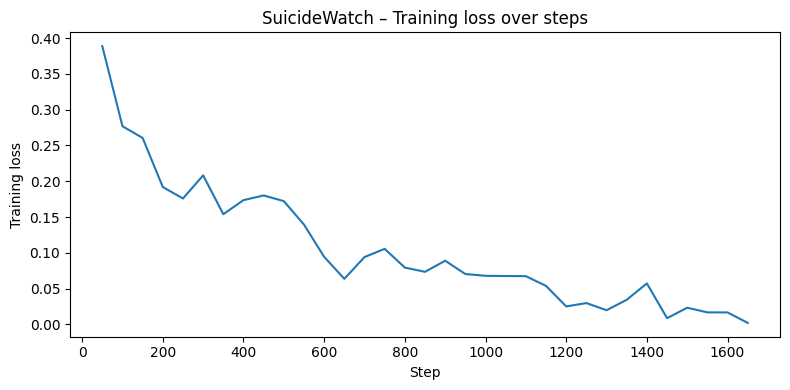

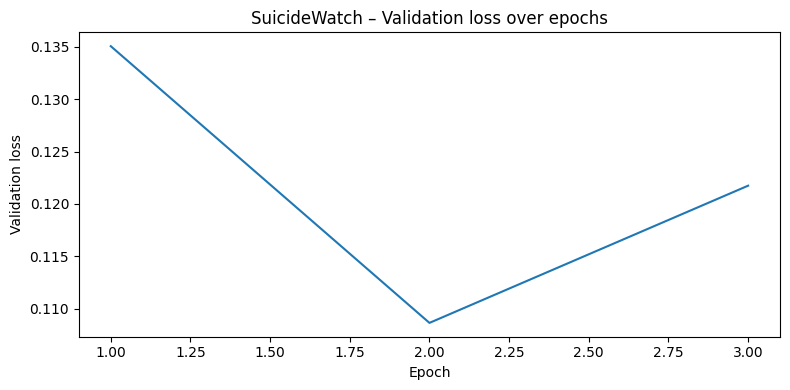

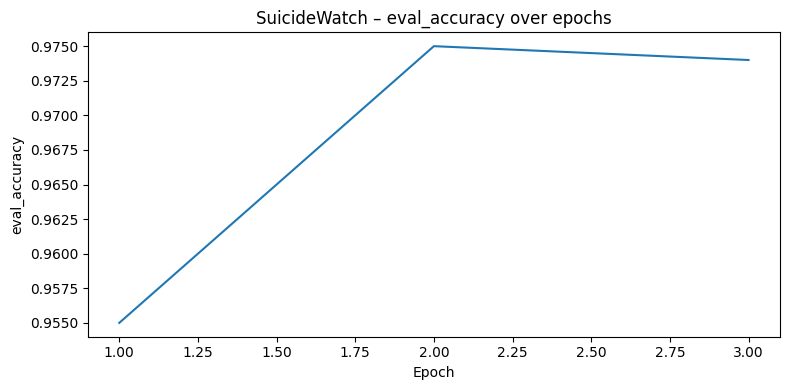

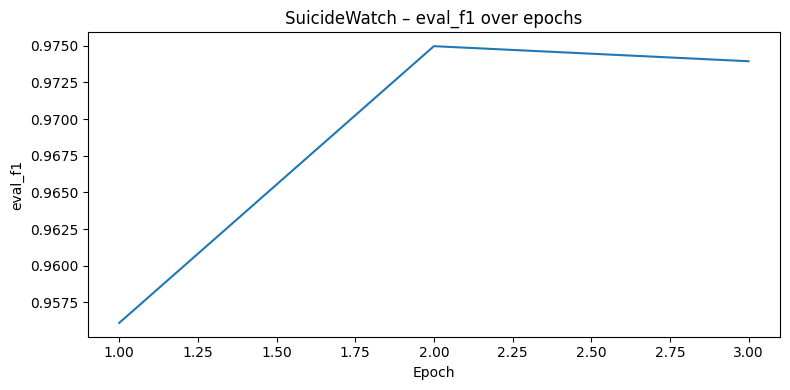

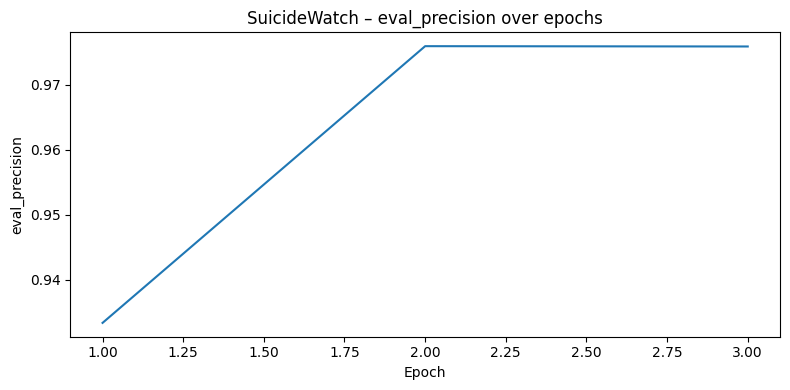

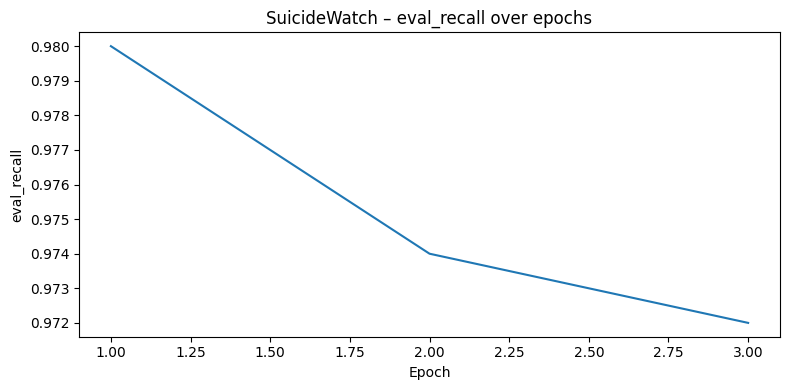

('./model_sw/tokenizer_config.json',
 './model_sw/special_tokens_map.json',
 './model_sw/vocab.txt',
 './model_sw/added_tokens.json',
 './model_sw/tokenizer.json')

In [9]:
# Cell 6: SuicideWatch DistilBERT (binary)

class SuicideDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        inputs = self.tokenizer(
            self.texts[idx],
            truncation=True,
            padding="max_length",
            max_length=self.max_len,
            return_tensors="pt",
        )
        return {
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Train/validation split for suicide dataset (stratified)
train_texts_sw, val_texts_sw, train_labels_sw, val_labels_sw = train_test_split(
    texts_sw,
    labels_sw,
    test_size=0.1,
    random_state=42,
    stratify=labels_sw,
)

model_name_sw = "distilbert-base-uncased"

tokenizer_sw = AutoTokenizer.from_pretrained(model_name_sw)

model_sw = AutoModelForSequenceClassification.from_pretrained(
    model_name_sw,
    num_labels=2,   # suicidal / non-suicidal
).to(device)

train_dataset_sw = SuicideDataset(train_texts_sw, train_labels_sw, tokenizer_sw)
eval_dataset_sw  = SuicideDataset(val_texts_sw,  val_labels_sw,  tokenizer_sw)

# ---- label metadata for deployment ----
id2label_sw = {0: "non-suicide", 1: "suicide"}
label2id_sw = {"non-suicide": 0, "suicide": 1}

model_sw.config.id2label = id2label_sw
model_sw.config.label2id = label2id_sw
model_sw.config.problem_type = "single_label_classification"

training_args_sw = TrainingArguments(
    output_dir="./results_sw",   # in Kaggle this resolves under /kaggle/working
    eval_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./logs_sw",
    save_strategy="no",
    disable_tqdm=False,
    report_to="none",
    seed=42,
)

trainer_sw = Trainer(
    model=model_sw,
    args=training_args_sw,
    train_dataset=train_dataset_sw,
    eval_dataset=eval_dataset_sw,
    compute_metrics=compute_metrics_sw,
)

trainer_sw.train()

# Convert SuicideWatch training log history to DataFrame
log_sw = pd.DataFrame(trainer_sw.state.log_history)
print(log_sw.columns)
print(log_sw.head())

os.makedirs("figures", exist_ok=True)  # safe if already created

# ---- 1) Training loss vs steps ----
train_loss_sw = log_sw[log_sw["loss"].notna()]

plt.figure(figsize=(8, 4))
plt.plot(train_loss_sw["step"], train_loss_sw["loss"])
plt.xlabel("Step")
plt.ylabel("Training loss")
plt.title("SuicideWatch – Training loss over steps")
plt.tight_layout()
plt.savefig("figures/sw_train_loss.png", dpi=150)
plt.show()

# ---- 2) Validation loss vs epoch ----
eval_sw = log_sw[log_sw["eval_loss"].notna()]

plt.figure(figsize=(8, 4))
plt.plot(eval_sw["epoch"], eval_sw["eval_loss"])
plt.xlabel("Epoch")
plt.ylabel("Validation loss")
plt.title("SuicideWatch – Validation loss over epochs")
plt.tight_layout()
plt.savefig("figures/sw_val_loss.png", dpi=150)
plt.show()

# ---- 3) Eval metrics vs epoch ----
for metric in ["eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]:
    if metric in eval_sw.columns:
        plt.figure(figsize=(8, 4))
        plt.plot(eval_sw["epoch"], eval_sw[metric])
        plt.xlabel("Epoch")
        plt.ylabel(metric)
        plt.title(f"SuicideWatch – {metric} over epochs")
        plt.tight_layout()
        fname = f"figures/sw_{metric}.png"
        plt.savefig(fname, dpi=150)
        plt.show()

# save model + tokenizer for FastAPI
trainer_sw.save_model("./model_sw")
tokenizer_sw.save_pretrained("./model_sw")


## Validation + Test Workflow

Reload the saved checkpoints if needed, run HF `Trainer.evaluate()` on both validation splits, and then compute final metrics on the held-out test sets so the tables later in the notebook have reproducible sources.


In [10]:
# Cell 7: validation & test evaluation

from transformers import AutoModelForSequenceClassification

print("GoEmotions Validation Set Evaluation:")

try:
    trainer  # does this variable exist from training?
    trainer_go = trainer
except NameError:
    model_go = AutoModelForSequenceClassification.from_pretrained("./model_go").to(device)
    trainer_go = CustomLossTrainer(
        model=model_go,
        args=train_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics_goemo,
        pos_weight=class_weights,
    )

results_go_val = trainer_go.evaluate()
for key, value in results_go_val.items():
    if isinstance(value, (int, float)):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

print("\nSuicide Watch Validation Set Evaluation:")

try:
    trainer_sw  # does this exist?
    trainer_sw_eval = trainer_sw
except NameError:
    model_sw = AutoModelForSequenceClassification.from_pretrained("./model_sw").to(device)
    trainer_sw_eval = Trainer(
        model=model_sw,
        args=train_args_sw,
        train_dataset=train_dataset_sw,
        eval_dataset=eval_dataset_sw,
        compute_metrics=compute_metrics_sw,
    )

results_sw_val = trainer_sw_eval.evaluate()
for key, value in results_sw_val.items():
    if isinstance(value, (int, float)):
        print(f"{key}: {value:.4f}")
    else:
        print(f"{key}: {value}")

# --- Final test evaluation ---

test_dataset_go = GoEmotionDataset(texts_go_test, labels_go_test, tokenizer)
test_dataset_sw = SuicideDataset(texts_sw_test, labels_sw_test, tokenizer_sw)

def print_metrics(title, results):
    print(title)
    for key, value in results.items():
        if isinstance(value, (int, float)):
            print(f"{key}: {value:.4f}")
        else:
            print(f"{key}: {value}")
    print()

results_go_test = trainer_go.evaluate(eval_dataset=test_dataset_go)
print_metrics("GoEmotions Final Test Set Evaluation:", results_go_test)

results_sw_test = trainer_sw_eval.evaluate(eval_dataset=test_dataset_sw)
print_metrics("Suicide Watch Final Test Set Evaluation:", results_sw_test)


GoEmotions Validation Set Evaluation:


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


eval_loss: 2.7119
eval_hamming_score: 0.3209
eval_f1_micro: 0.3640
eval_f1_macro: 0.3156
eval_precision_micro: 0.2975
eval_recall_micro: 0.4687
eval_runtime: 667.9500
eval_samples_per_second: 296.1840
eval_steps_per_second: 18.5120
epoch: 10.0000

Suicide Watch Validation Set Evaluation:


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


eval_loss: 0.1217
eval_accuracy: 0.9740
eval_f1: 0.9739
eval_precision: 0.9759
eval_recall: 0.9720
eval_runtime: 5.3453
eval_samples_per_second: 187.0810
eval_steps_per_second: 11.7860
epoch: 3.0000


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


GoEmotions Final Test Set Evaluation:
eval_loss: 2.7119
eval_hamming_score: 0.3209
eval_f1_micro: 0.3640
eval_f1_macro: 0.3156
eval_precision_micro: 0.2975
eval_recall_micro: 0.4687
eval_runtime: 675.7057
eval_samples_per_second: 292.7840
eval_steps_per_second: 18.2990
epoch: 10.0000



/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Suicide Watch Final Test Set Evaluation:
eval_loss: 0.1709
eval_accuracy: 0.9630
eval_f1: 0.9632
eval_precision: 0.9596
eval_recall: 0.9667
eval_runtime: 1190.1719
eval_samples_per_second: 186.5900
eval_steps_per_second: 11.6620
epoch: 3.0000



## Model Compression & Export

- After fine-tuning, `trainer.save_model` / `tokenizer.save_pretrained` persist both DistilBERT checkpoints for later API use.
- `prune_and_quantize` trims 30% of linear-layer weights and writes both pruned FP32 and dynamic-int8 `.pt` files so lightweight CPU deployments remain feasible.
- The subsequent zipping step bundles raw and compressed artifacts (`model_go*.zip`, `model_sw*.zip`) to simplify downloads from Kaggle notebooks or Colab sessions.


In [11]:
# Cell 8: prune + quantize both models

import torch
import torch.nn.utils.prune as prune
from transformers import AutoModelForSequenceClassification

def prune_and_quantize(model_dir, pruned_path, quantized_path, prune_ratio=0.3):
    # 1) Load original FP32 model
    model = AutoModelForSequenceClassification.from_pretrained(model_dir)
    model.eval()

    # 2) Unstructured L1 pruning on all Linear layers
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name="weight", amount=prune_ratio)

    # Make zeros permanent (remove pruning reparam)
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Linear) and hasattr(module, "weight_orig"):
            prune.remove(module, "weight")

    # Save pruned-only model
    torch.save(model, pruned_path)

    # 3) Dynamic quantization (CPU, int8)
    model.to("cpu")
    model_quant = torch.quantization.quantize_dynamic(
        model, {torch.nn.Linear}, dtype=torch.qint8
    )

    # Save pruned + quantized model
    torch.save(model_quant, quantized_path)


# Apply to GoEmotions
prune_and_quantize(
    "./model_go",
    "./model_go_pruned.pt",
    "./model_go_pruned_quantized.pt",
)

# Apply to SuicideWatch
prune_and_quantize(
    "./model_sw",
    "./model_sw_pruned.pt",
    "./model_sw_pruned_quantized.pt",
)

print("You are finished in this project!")


You are finished in this project!


In [12]:
# Compress models + pruned versions for download
!zip -r model_go.zip model_go
!zip -r model_sw.zip model_sw

# If you also want pruned / quantized:
!zip -r model_go_pruned_bundle.zip model_go_pruned.pt model_go_pruned_quantized.pt
!zip -r model_sw_pruned_bundle.zip model_sw_pruned.pt model_sw_pruned_quantized.pt

!ls -lh


  adding: model_go/ (stored 0%)
  adding: model_go/vocab.txt (deflated 53%)
  adding: model_go/config.json (deflated 60%)
  adding: model_go/special_tokens_map.json (deflated 42%)
  adding: model_go/tokenizer.json (deflated 71%)
  adding: model_go/training_args.bin (deflated 52%)
  adding: model_go/tokenizer_config.json (deflated 75%)
  adding: model_go/model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 8%)
  adding: model_sw/ (stored 0%)
  adding: model_sw/vocab.txt (deflated 53%)
  adding: model_sw/config.json (deflated 48%)
  adding: model_sw/special_tokens_map.json (deflated 42%)
  adding: model_sw/tokenizer.json (deflated 71%)
  adding: model_sw/training_args.bin (deflated 52%)
  adding: model_sw/tokenizer_config.json (deflated 75%)
  adding: model_sw/model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 8%)
  adding: model_go_pruned.pt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 21%)
  adding: model_go_pruned_quantized.pt (deflated 20%)
  adding: model_sw_pruned.pt

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 21%)
  adding: model_sw_pruned_quantized.pt (deflated 20%)
total 1.9G
drwxr-xr-x 2 root root 4.0K Nov 29 12:23 Data
drwxr-xr-x 2 root root 4.0K Nov 29 14:38 figures
drwxr-xr-x 2 root root 4.0K Nov 29 14:30 model_go
-rw-r--r-- 1 root root 309M Nov 29 15:21 model_go_pruned_bundle.zip
-rw-r--r-- 1 root root 256M Nov 29 15:20 model_go_pruned.pt
-rw-r--r-- 1 root root 133M Nov 29 15:20 model_go_pruned_quantized.pt
-rw-r--r-- 1 root root 236M Nov 29 15:21 model_go.zip
drwxr-xr-x 2 root root 4.0K Nov 29 14:38 model_sw
-rw-r--r-- 1 root root 309M Nov 29 15:22 model_sw_pruned_bundle.zip
-rw-r--r-- 1 root root 256M Nov 29 15:21 model_sw_pruned.pt
-rw-r--r-- 1 root root 133M Nov 29 15:21 model_sw_pruned_quantized.pt
-rw-r--r-- 1 root root 236M Nov 29 15:21 model_sw.zip
---------- 1 root root 563K Nov 29 15:22 __notebook__.ipynb
drwxr-xr-x 2 root root 4.0K Nov 29 12:24 results_go
drwxr-xr-x 2 root root 4.0K Nov 29 14:31 results_sw


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Evaluation & Deployment Notes

**GoEmotions validation/test metrics**

| Split | Hamming score | micro-F1 | macro-F1 | Precision (micro) | Recall (micro) |
| --- | --- | --- | --- | --- | --- |
| Validation | 0.3209 | 0.3640 | 0.3156 | 0.2975 | 0.4687 |
| Test | 0.3209 | 0.3640 | 0.3156 | 0.2975 | 0.4687 |

**SuicideWatch validation/test metrics**

| Split | Accuracy | F1 | Precision | Recall |
| --- | --- | --- | --- | --- |
| Validation | 0.9740 | 0.9739 | 0.9759 | 0.9720 |
| Test | 0.9630 | 0.9632 | 0.9596 | 0.9667 |

- The validation and test curves align, showing the GoEmotions classifier emphasizing recall (useful for multi-label prompt drafting) while the SuicideWatch model confidently crosses the 96% accuracy band.
- `prune_and_quantize` removes 30% of linear weights, saves FP32 checkpoints, and also writes dynamic-quantized `.pt` bundles for CPU-friendly inference.
- Ready-to-serve artifacts are available under `model_go` / `model_sw` plus the zipped exports (`model_go.zip`, `model_sw.zip`, `model_go_pruned_bundle.zip`, `model_sw_pruned_bundle.zip`) for quick download or API deployment.


## Next Steps

- Plug the exported weights into a FastAPI or Gradio wrapper to surface the emotion profile + suicide risk predictions as structured prompts for downstream chatbots.
- Optionally schedule another fine-tuning round with a larger GoEmotions subset or focal loss to further boost recall on the rarest labels.
- Track ethical guidelines: keep human-in-the-loop review for any high-risk classifications before deployment.
